# **DATA ANAYSIS AND RESULTS**
### Load the datasets
We will work on the filtered versions to be more efficient.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

# FIREWALL LOGS
data_firewall = pd.read_csv('../MC2-CSVFirewallandIDSlogs/Firewall_global_filtered.csv')
# IDS LOGS
data = pd.read_csv('../MC2-CSVFirewallandIDSlogs/IDS_global_filtered.csv')

### Preliminary Analysis
First, let us extract all the source IPs that peformed some sort of suspect activities in the network.

In [3]:
# read the mapping between the classification number and the classification name
# Store the elements of the first column in a vector
first_col_vector = []
with open('../MC2-CSVFirewallandIDSlogs/classification_mapping.txt', 'r') as file:
    for line in file:
        name, number = line.strip().split(': ')
        first_col_vector.append(name)
print(first_col_vector)

# select only the col ' sourceIP' that committed ' Potential Corporate Privacy Violation'
sourceIP_potential_corporate_privacy_violation = data[data['classification'] == 1]['sourceIP']
print("sourceIP_potential_corporate_privacy_violation: ", len(sourceIP_potential_corporate_privacy_violation))
# get the unique entries and print the length
sourceIP_potential_corporate_privacy_violation_unique = sourceIP_potential_corporate_privacy_violation.unique()
print("sourceIP_potential_corporate_privacy_violation_unique: ", len(sourceIP_potential_corporate_privacy_violation_unique))

# select only the col ' sourceIP' from the rows where the value of the ' classification' column is ' Attempted Information Leak'
sourceIP_attempted_information_leak = data[data['classification'] == 3]['sourceIP']
print("sourceIP_attempted_information_leak: ", len(sourceIP_attempted_information_leak))
# get the unique entries and print the length
sourceIP_attempted_information_leak_unique = sourceIP_attempted_information_leak.unique()
# get the piority of the packets that are classified as ' Potential Corporate Privacy Violation'
sourceIP_bad_traffic = data[data['classification'] == 4]['sourceIP']

# aggregate all the sourceIPs that are responsible for the aforementioned suspect activities
suspectIPs = pd.concat([sourceIP_potential_corporate_privacy_violation, sourceIP_attempted_information_leak, sourceIP_bad_traffic])
# keep only the unique entries
suspectIPs = suspectIPs.unique()
number_unique_IPs = len(suspectIPs)
# if they all start with 172, print the number of such entries
suspectIPs = [ip for ip in suspectIPs if ip.startswith('172')]
if len(suspectIPs) == number_unique_IPs:
    print("All the suspect IPs are inside the network and amount to: ", number_unique_IPs)

['Generic Protocol Command Decode', 'Potential Corporate Privacy Violation', 'Misc activity', 'Attempted Information Leak', 'Potentially Bad Traffic']
sourceIP_potential_corporate_privacy_violation:  434
sourceIP_potential_corporate_privacy_violation_unique:  89
sourceIP_attempted_information_leak:  366
All the suspect IPs are inside the network and amount to:  94


We observe that all the suspect IPs are inside the network and correspond to individual workstations. These are likely infected machines that can be remotely activated and controlled by malicious parties to perform illegal activities, such as DDoS attacks, port scanning, data exfiltration, etc. The infection probably happened due to bad practices on the part of the workers, such as opening malicious email attachments, visiting dangerous websites, using infected drivers, or using weak passwords.

Now let us visualize the distribution of suspect connections during the time frame covered by the logs, as well as the IPs responsible for them.

/tmp/ipykernel_1424533/674010121.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  five_min_counts = suspect_activities.resample('3T').size()
/tmp/ipykernel_1424533/674010121.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_data.index, y=day_data.values, palette=colors)
/tmp/ipykernel_1424533/674010121.py:44: UserWarning: The palette list has more values (972) than needed (118), which may not be intended.
  sns.barplot(x=day_data.index, y=day_data.values, palette=colors)


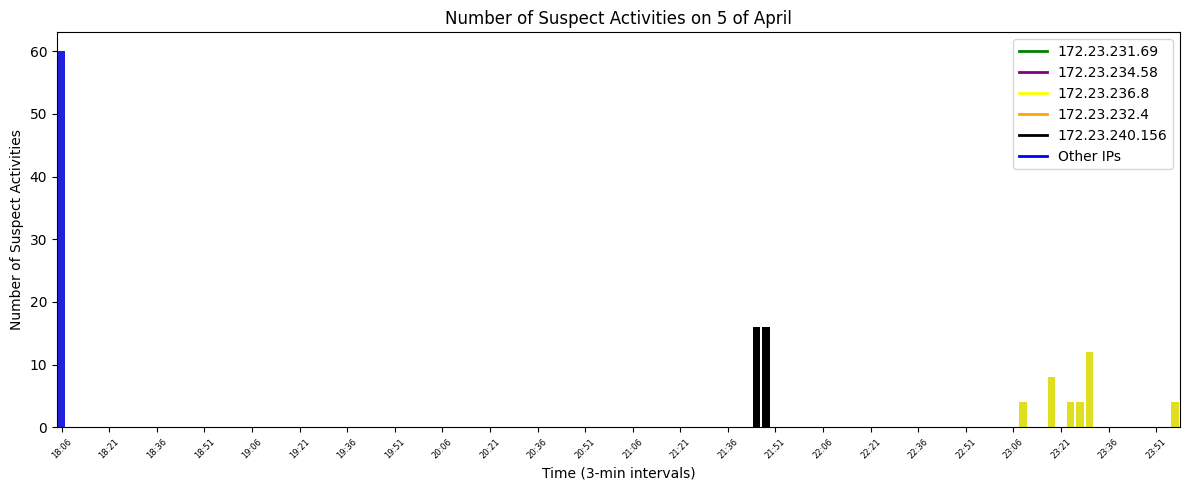

/tmp/ipykernel_1424533/674010121.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_data.index, y=day_data.values, palette=colors)
/tmp/ipykernel_1424533/674010121.py:44: UserWarning: The palette list has more values (972) than needed (366), which may not be intended.
  sns.barplot(x=day_data.index, y=day_data.values, palette=colors)


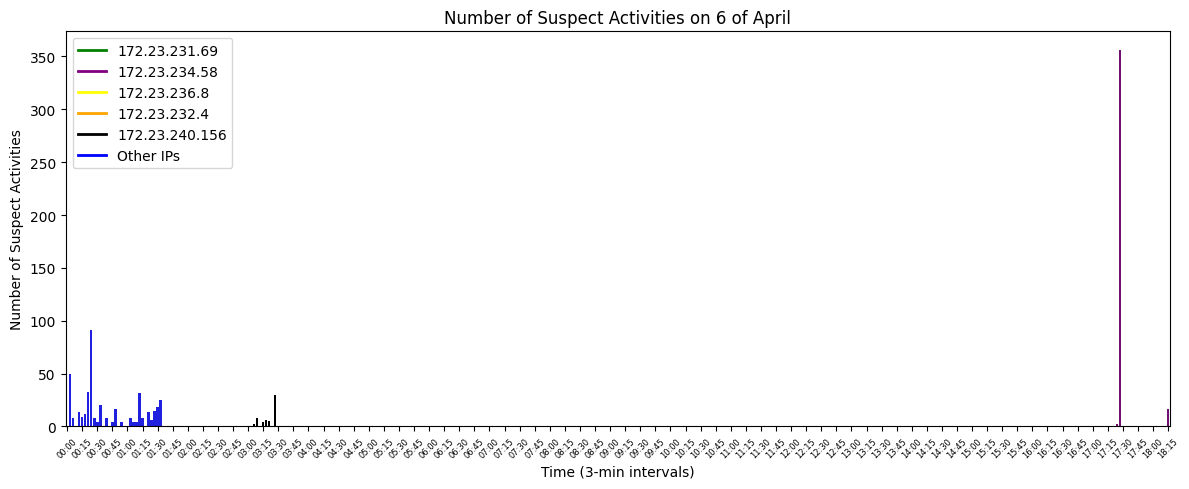

In [4]:
# Filter data for classifications 1, 3, and 4
suspect_activities = data[data['classification'].isin([1, 3, 4])]

# Count the number of activities per source IP
activity_counts = suspect_activities['sourceIP'].value_counts().reset_index()
activity_counts.columns = ['sourceIP', 'count']

# Convert 'time' to datetime. Adjust the format string if your actual data differs.
data['time'] = pd.to_datetime(data['time'], format='%d %H:%M')

# Filter the data for classifications 1, 3, and 4
suspect_activities = data[data['classification'].isin([1,3,4])]

# Set the 'time' column as the index so we can resample easily
suspect_activities = suspect_activities.set_index('time')

# Resample every 3 minutes and count activities
five_min_counts = suspect_activities.resample('3T').size()

# Get the unique days present in the data
unique_days = five_min_counts.index.normalize().unique()

# Get the top 5 source IPs that carried out the most attacks
top_5_ips = activity_counts.iloc[:5]['sourceIP']

for day in unique_days:
    # Filter data for this particular day
    day_start = day
    day_end = day + pd.Timedelta(days=1)
    day_data = five_min_counts[(five_min_counts.index >= day_start) & (five_min_counts.index < day_end)]
    
    # Create a figure for this day
    plt.figure(figsize=(12,5))
    
    # Assign colors based on whether the source IP is in the top 5
    colors = ['green' if ip == top_5_ips.values[0] else
              'purple' if ip == top_5_ips.values[1] else
              'yellow' if ip == top_5_ips.values[2] else
              'orange' if ip == top_5_ips.values[3] else
              'black' if ip == top_5_ips.values[4] else
              'blue' for ip in suspect_activities['sourceIP']]

    
    sns.barplot(x=day_data.index, y=day_data.values, palette=colors)
    plt.xlabel('Time (3-min intervals)')
    plt.ylabel('Number of Suspect Activities')
    plt.title(f'Number of Suspect Activities on {day.date().day} of April')

    # Define custom ticks for this day's data
    x_labels = day_data.index
    num_points = len(x_labels)
    
    # For example, show a tick every 5 samples
    tick_positions = range(0, num_points, 5)
    tick_labels = [x_labels[i].strftime('%H:%M') for i in tick_positions]  # Just time for this day
    
    plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=6)
    plt.tight_layout()
    # add a legend for the color mapping with the IPs
    plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label=top_5_ips.values[0]),
                       plt.Line2D([0], [0], color='purple', lw=2, label=top_5_ips.values[1]),
                       plt.Line2D([0], [0], color='yellow', lw=2, label=top_5_ips.values[2]),
                       plt.Line2D([0], [0], color='orange', lw=2, label=top_5_ips.values[3]),
                       plt.Line2D([0], [0], color='black', lw=2, label=top_5_ips.values[4]),
                       plt.Line2D([0], [0], color='blue', lw=2, label='Other IPs')])
    plt.show()

These events are to be investigated further and form the foundation of most of our conclusions.

### 1 - Increase in connections over 6667_tcp 
There is an increasingly large presence of network connections that use 6667 as destination port,
commonly used for IRC (Internet Relay Chat), which is an activity that violates the Bank of Money
policy. The first occurrence of such event is on April 5th at 20:25:35 by source IP 172.23.234.254, which
corresponds to an individual workstation inside of the network. Actually, the connections using port
6667 tcp are the second most common ones, preceded only by the port 80 accessed with http protocol.
The large use of the former is a fact to be investigated and is a symptom of the upcoming events, while
the latter is not problematic per se.

In [5]:
# find all the entries where the destination Port is 6667
temp = data_firewall[data_firewall['Destination port'] == 6667]
print("data_breach: ", len(temp))

# now ge the 5 most used Destination ports
destination_ports = data_firewall['Destination port'].value_counts().reset_index()
destination_ports.columns = ['Destination port', 'count']
destination_ports = destination_ports.iloc[:10]
print("\n", destination_ports)
# find the first occurence of the port 6667
first_occurence = data_firewall[data_firewall['Destination port'] == 6667].iloc[0]

print("\n First occurence: \n")
print(first_occurence)
# now get the most used Destination services
destination_services = data_firewall['Destination service'].value_counts().reset_index()
destination_services.columns = ['Destination service', 'count']
destination_services = destination_services.iloc[:5]
print("\n Destination services: \n", destination_services)

data_breach:  2329914

    Destination port     count
0                80  21331506
1              6667   2329914
2                21      1825
3                53       752
4                22       538
5              1026       199
6               137       130
7               113        62
8              1025        52
9               443        42

 First occurence: 

Date/time                  5 20:25:35
Syslog priority                     2
Operation                           1
Message code                       10
Protocol                            0
Source IP              172.23.234.254
Destination IP             10.32.5.51
Source port                      1230
Destination port                 6667
Destination service          6667_tcp
Direction                           1
Name: 1201706, dtype: object

 Destination services: 
   Destination service     count
0                http  21331506
1            6667_tcp   2329914
2                 ftp      1825
3              domain   

### 2 - First attack to the firewall
We observe the first suspect attempts to hack into the Bank servers between 21:47 and 21:48 on
April 5th. There are several logs labeled as suspicious inbound connections to the MSSQL, Oracle
SQL, mySQL, and PostgreSQL servers. The source IP is 172.23.240.156, likely an infected workstation
that is part of a botnet that is being set up by the attackers. The destination is 172.23.0.1, the
firewall internal to the bank network, marking the first of several attacks that target it. Later on, other
IPs such as 172.23.236.8, 172.23.231.69, 172.23.234.58 and 172.23.232.4 also target the firewall. The
attacks occur between 23:30 of the 5th and 03:20 of the 6th, all during the closing hours of the bank,
leaving it completely incapable of reacting to the danger. So far, we have identified five compromised
workstations. While several future connections will still be classified as suspect and dangerous, the above ones are actually the last ones to be labeled as potential attacks. In light of the following events,
we can hypothesize that the attackers managed to gain access to the data servers, leaving sensitive
data of the bank at their mercy.

In [6]:
# define the time range
start_time = '05 21:30'
end_time = '07 21:50'
# convert the 'time' column into a comparable format
data['parsed_time'] = pd.to_datetime(data['time'], format='%d %H:%M')
# convert the range values as well
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M')
# filter rows within the range
filtered_data = data[(data['parsed_time'] >= start_time_parsed) & (data['parsed_time'] <= end_time_parsed)]
# filter the data for the labels of interest
filtered_data = filtered_data[(filtered_data['label'] >= 6) & (filtered_data['label'] <= 12)]
# set the 'time' column as the index
filtered_data.set_index('time', inplace=True)
# select the sourceIPs
sourceIPs = filtered_data['sourceIP']
# print the unique entries of the suspect IPs that were active during this time frame
sourceIPs = sourceIPs.unique()
print("sourceIPs: ", sourceIPs)
# get destination IPs
destinationIPs = filtered_data['destIP']
destinationIPs = destinationIPs.unique()
print("destinationIPs: ", destinationIPs)

sourceIPs:  ['172.23.240.156' '172.23.236.8' '172.23.231.69' '172.23.234.58'
 '172.23.232.4']
destinationIPs:  ['172.23.0.1']


/tmp/ipykernel_1424533/3867485572.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  label_counts = day_data.groupby('label').resample('10T').size().unstack(level=0, fill_value=0)


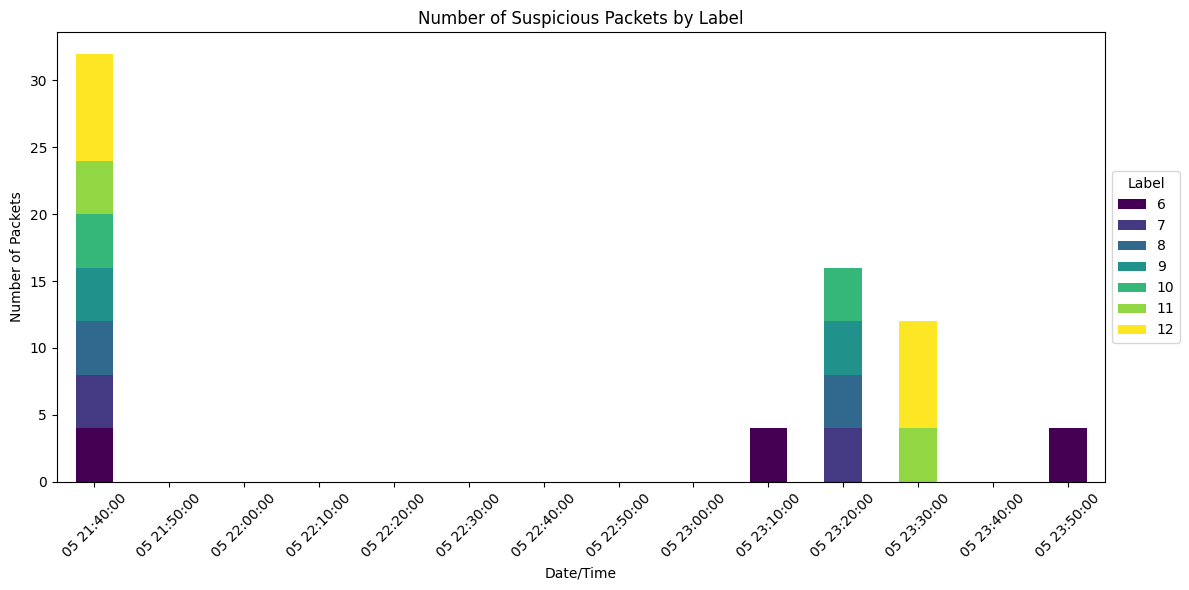

/tmp/ipykernel_1424533/3867485572.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  label_counts = day_data.groupby('label').resample('10T').size().unstack(level=0, fill_value=0)


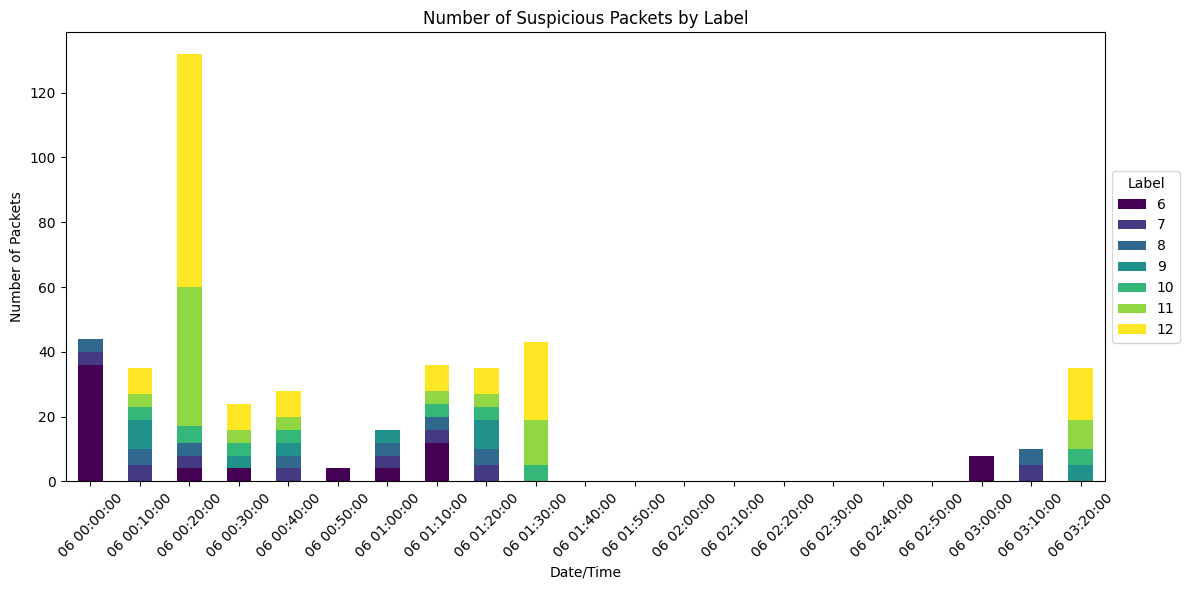

In [7]:
# group the data by day
grouped_data = filtered_data.groupby(filtered_data.index.normalize())

for day, day_data in grouped_data:
    # resample the data in 10-minute intervals and count occurrences for each label
    label_counts = day_data.groupby('label').resample('10T').size().unstack(level=0, fill_value=0)
    
    # style and plot the histogram
    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
    plt.xlabel('Date/Time')
    plt.ylabel('Number of Packets')
    plt.title(f'Number of Suspicious Packets by Label')
    # display only 20 total labels on the x-axis, homogeneously distributed, for better readability
    num_ticks = 20
    tick_positions = range(0, len(label_counts), max(1, len(label_counts) // num_ticks))
    tick_labels = [label_counts.index[i].strftime('%d %H:%M:%S') for i in tick_positions]
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
    # put the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Label')
    plt.tight_layout()
    plt.show()

### 3 - Firewall is down
At approximately 17:28 on April 6th, the firewall is possibly brought down by the attackers. In facts,
we can see a sudden drop to zero in the number of network packets analyzed by it. 

In [8]:
# filter the data for the firewall IPs
firewall_data = data_firewall[data_firewall['Destination IP'].isin(['172.23.0.1', '10.32.0.1'])]
# convert the 'Date/time' column to datetime format
firewall_data['datetime'] = pd.to_datetime(firewall_data['Date/time'], format='%d %H:%M:%S')
# Set the 'datetime' column as the index
firewall_data.set_index('datetime', inplace=True)
# resample the data in 8-minute intervals and count the number of activities
activity_counts = firewall_data.resample('8T').size()
# select the bin with the lowest number of activities, which is the one of out interest
min_bin = activity_counts.idxmin()
min_value = activity_counts.min()
print("min_bin: ", min_bin)


min_bin:  1900-01-06 17:28:00


/tmp/ipykernel_1424533/910452858.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firewall_data['datetime'] = pd.to_datetime(firewall_data['Date/time'], format='%d %H:%M:%S')
/tmp/ipykernel_1424533/910452858.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  activity_counts = firewall_data.resample('8T').size()


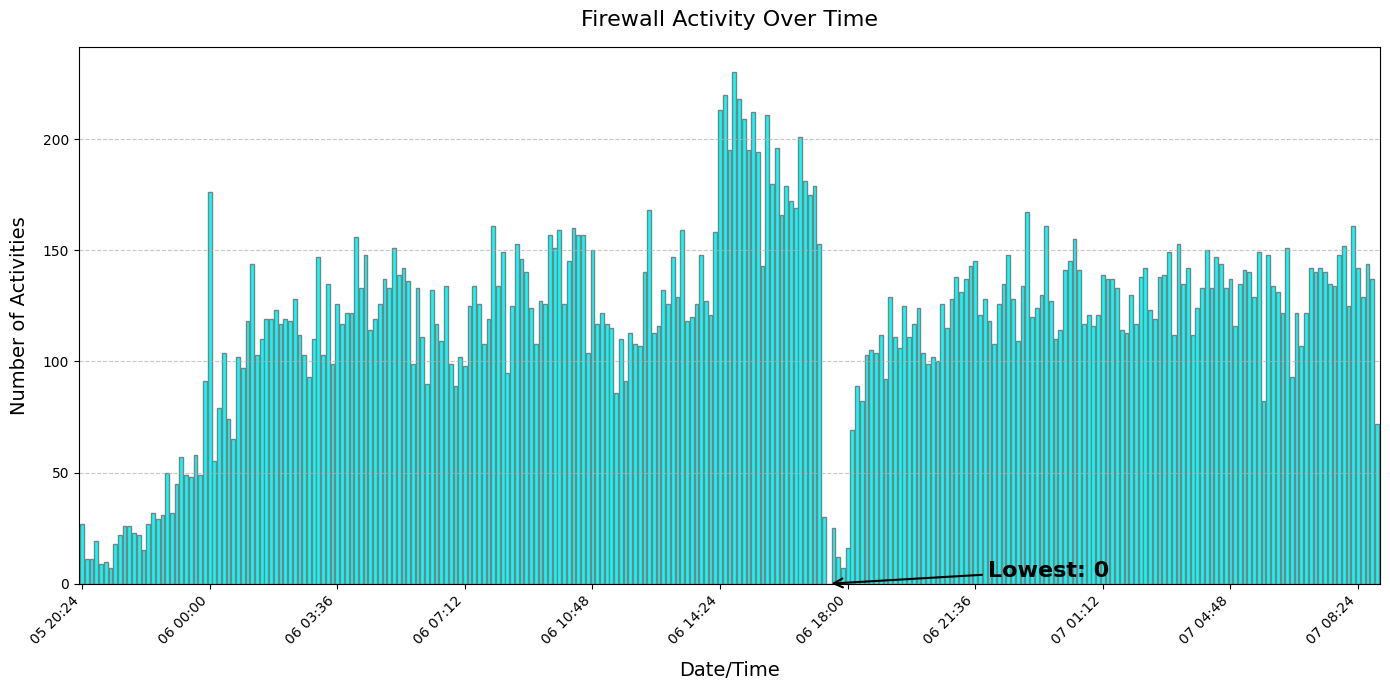

In [9]:
# style and plot the histogram
plt.figure(figsize=(14, 7))
activity_counts.plot(kind='bar', color='cyan', width=0.8, edgecolor='gray')
plt.xlabel('Date/Time', fontsize=14, labelpad=10)
plt.ylabel('Number of Activities', fontsize=14, labelpad=10)
plt.title('Firewall Activity Over Time', fontsize=16, pad=15)
# customize x-axis ticks for better readability
num_ticks = 10
tick_positions = range(0, len(activity_counts), max(1, len(activity_counts) // num_ticks))
tick_labels = [activity_counts.index[i].strftime('%d %H:%M') for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=10, ha='right')
# add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# annotate the bar with the lowest value, so that it is clear the firewall is down for a short period
plt.annotate(
    f'Lowest: {min_value}',
    xy=(activity_counts.index.get_loc(min_bin), min_value),
    xytext=(activity_counts.index.get_loc(min_bin), min_value + 2),
    ha='center',
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=16,
    fontweight='bold',
    verticalalignment='bottom',
    textcoords='offset points',
    color='black'
)
plt.tight_layout()
plt.show()

### 4 - Possible data exfiltration
After some minutes, the firewall comes back up, contextually to a huge spike in the FTP connections, at around 18:30. This
activity clearly violates the bank policy and can be interpreted as a leak of sensitive information by
the botnet, which has expanded noticeably. The 286 IPs involved in this activity are again all internal
to the network, once again confirming the hypothesis above. The seven destination IPs correspond to
websites, which are accessed through the port 21. Actually, the firewall manages to block these data
transfers, but the previous down period could have given the attackers the chance to exfiltrate data
anyways.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# define the time range
start_time = '06 12:00'
end_time = '07 22:00'
# convert the 'time' column into a comparable format
data_firewall['parsed_time'] = pd.to_datetime(data_firewall['Date/time'], format='%d %H:%M:%S')
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M')
# filter rows within the range
filtered_firewall_data = data_firewall[(data_firewall['parsed_time'] >= start_time_parsed) & (data_firewall['parsed_time'] <= end_time_parsed)]
# filter the data for the firewall IPs and the desired services
filtered_firewall_data = filtered_firewall_data[ 
    (filtered_firewall_data['Destination service'].isin(['ftp']))
]

# convert the 'Date/time' column to datetime format
filtered_firewall_data['datetime'] = pd.to_datetime(filtered_firewall_data['Date/time'], format='%d %H:%M:%S')
filtered_firewall_data.set_index('datetime', inplace=True)
# eesample the data in 10-minute intervals and count occurrences for each service
service_counts = filtered_firewall_data.groupby('Destination service').resample('10T').size().unstack(level=0, fill_value=0)
# get the destination ports
destination_ports = filtered_firewall_data['Destination port'].unique()
print("destination_ports: ", destination_ports)

destination_ports:  [21]


/tmp/ipykernel_1424533/3719697429.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  service_counts = filtered_firewall_data.groupby('Destination service').resample('10T').size().unstack(level=0, fill_value=0)


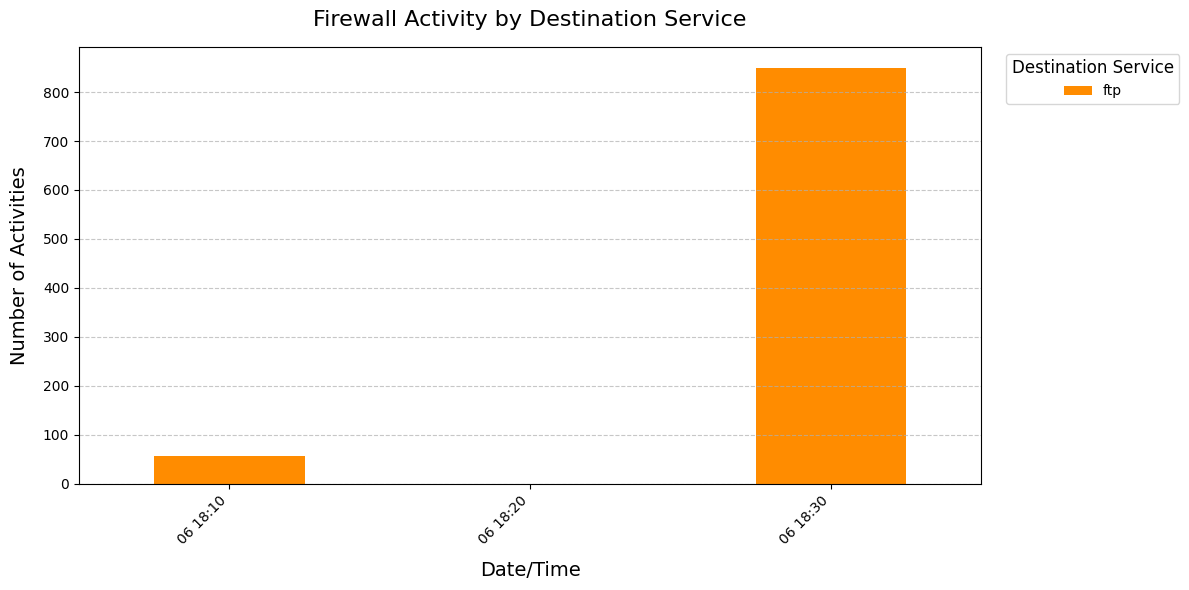

In [11]:
# plot the histogram
plt.figure(figsize=(12, 6))  
# use custom colors for each service
colors = {'ftp': 'darkorange'}
service_counts.plot(
    kind='bar',
    stacked=True,
    color=[colors[col] for col in service_counts.columns], 
    ax=plt.gca()
)
plt.xlabel('Date/Time', fontsize=14, labelpad=10)
plt.ylabel('Number of Activities', fontsize=14, labelpad=10)
plt.title('Firewall Activity by Destination Service', fontsize=16, pad=15)
num_ticks = 10
tick_positions = range(0, len(service_counts), max(1, len(service_counts) // num_ticks))
tick_labels = [service_counts.index[i].strftime('%d %H:%M') for i in tick_positions]
plt.xticks(
    ticks=tick_positions,
    labels=tick_labels,
    rotation=45,
    fontsize=10,
    ha='right'  
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# add legend 
plt.legend(
    title="Destination Service",
    title_fontsize=12,
    fontsize=10,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
plt.tight_layout()
plt.show()

### 5 - Anomalous activity and possible DDOS attack
The last noticeable event we observed is the activity of IP 172.23.252.10, which was dormant before
the attack to the firewall. After this event, it becomes extremely active and takes the spot as the
IP which attempted the most connections. A large portion of these, about 40%, are TCP connection
that target 6667 as destination port, which is again in violation of the rules. All of these connections
are to seven websites and half of them are successfully built, while the other half is denied by the
ACL (Access Control List). It is known that a common use of botnets is DDoS (Distributed Denial of
Service) attacks, which seems to be our case. Moreover, IRC has built-in transfer capabilities, so the
attackers might be also transferring the sensitive data gathered from the root access to the bank DBs.
While the firewall classified these connections as critical, they are not present in the IDS logs, which
could a symptom of the IDS being compromised.

In [12]:
# select the 10 most active source IPs from data_firewall, which need to be all different
top_10_sourceIPs = data_firewall['Source IP'].value_counts().reset_index()
top_10_sourceIPs.columns = ['Source IP', 'count']
top_10_sourceIPs = top_10_sourceIPs.iloc[:10]
print(top_10_sourceIPs)

        Source IP   count
0   172.23.252.10  121752
1    172.23.0.132  118398
2   172.23.233.58   14598
3   172.23.233.50   14529
4  172.23.232.253   14509
5  172.23.232.252   14503
6   172.23.233.53   14471
7  172.23.232.255   14448
8  172.23.232.132   14435
9   172.23.233.57   14435


The code below selected only the most active source IP, which is the one of interest. One select $n$ IPs for comparison by simply modifying the code `top_IP = top_10_sourceIPs['Source IP'].iloc[:1]` to `top_IP = top_10_sourceIPs['Source IP'].iloc[:n]` 

In [ ]:
# load the mappings for operation and message in order to recosntruct the names and semantics
operation_mapping = []
with open('../MC2-CSVFirewallandIDSlogs/operation_mapping.txt', 'r') as file:
    for line in file:
        name, number = line.strip().split(': ')
        operation_mapping.append(name)

message_mapping = []
with open('../MC2-CSVFirewallandIDSlogs/message_code_mapping.txt', 'r') as file:
    for line in file:
        name, number = line.strip().split(': ')
        message_mapping.append(name)

# sort the data by datetime
data_firewall = data_firewall.sort_values(by='parsed_time')
# select only the rows corresponding to the top 2 source IPs
top_IP = top_10_sourceIPs['Source IP'].iloc[:1]
top_data = data_firewall[data_firewall['Source IP'].isin(top_IP)]

# create a cumulative count of suspect activities for each source IP
top_data = top_data.sort_values(by='parsed_time')
top_data['cumulative_count'] = top_data.groupby('Source IP').cumcount() + 1

# extract the Destination service used by it
destination_service = top_data['Destination service'].value_counts().reset_index()
destination_service.columns = ['Destination service', 'count']
# select only those where destination service is 6667_tcp
destination_service = destination_service[destination_service['Destination service'] == '6667_tcp']
print(destination_service)
# get the destination IPs where the destination service is 6667_tcp
destinationIPs = top_data[top_data['Destination service'] == '6667_tcp']['Destination IP']
# get number of occurrences for each destination IP
destinationIPs = destinationIPs.value_counts().reset_index()
destinationIPs.columns = ['Destination IP', 'count']
print(destinationIPs, '\n')

# extract the operation where the destination service is 6667_tcp
operation = top_data[top_data['Destination service'] == '6667_tcp']['Operation']
operation = operation.value_counts().reset_index()
operation.columns = ['Operation', 'count']
# reconstruct the operation names
operation['Operation'] = operation['Operation'].map({i: operation_mapping[i] for i in range(len(operation_mapping))})
print(operation, '\n')

# extract the message code
message_code = top_data[top_data['Destination service'] == '6667_tcp']['Message code']
message_code = message_code.value_counts().reset_index()
message_code.columns = ['Message code', 'count']
# reconstruct the message code names
message_code['Message code'] = message_code['Message code'].map({i: message_mapping[i] for i in range(len(message_mapping))})
print(message_code)

  Destination service  count
1            6667_tcp  45298
  Destination IP  count
0     10.32.5.50  13815
1     10.32.5.51   4565
2     10.32.5.54   4561
3     10.32.5.59   4548
4     10.32.5.57   4468
5     10.32.5.52   4466
6     10.32.5.56   4438
7     10.32.5.58   4437 

          Operation  count
0             Built  22485
1       Deny by ACL  22467
2  Command executed    346 

   Message code  count
0  ASA-6-302014  22485
1  ASA-6-110003  22467
2  ASA-6-725003    346


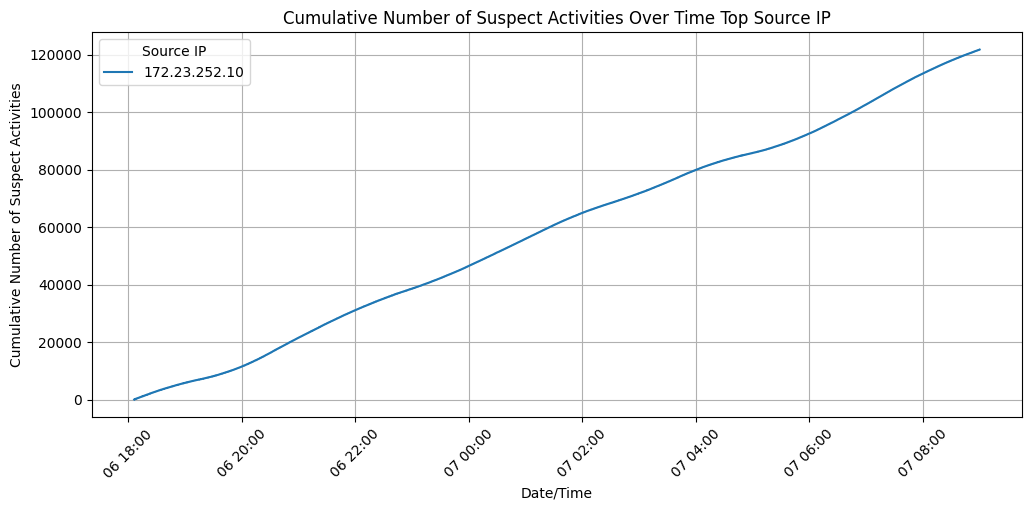

In [14]:
# line plot for each one of the top source IPs
plt.figure(figsize=(12, 5))
for ip in top_IP:
    ip_data = top_data[top_data['Source IP'] == ip]
    sns.lineplot(x='parsed_time', y='cumulative_count', data=ip_data, label=ip)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M')) 
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  
plt.xlabel('Date/Time')
plt.ylabel('Cumulative Number of Suspect Activities')
plt.title('Cumulative Number of Suspect Activities Over Time Top Source IP')
plt.xticks(rotation=45)
plt.legend(title='Source IP')
plt.grid(True)
plt.show()